# Real-Life experiment on the TCLab platform

## Import libs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from scipy.optimize import minimize

from datetime import datetime
import os


import tclab
import time

import package_DBR
from package_LAB import *
from package_DBR import *

## Experiment params

In [2]:
TSim = 1800
Ts = 1.0

# Initial working points 
MV0 = 50
DV0 = 50

# Paths
SPPath = {0: 75, 900: 65}
DVPath = {0: DV0, 1500: DV0+5}
manPath = {0: True, TSim: True}
manMVPath = {0: MV0, TSim: MV0}
ActivateFF = True

# Parameters for input-output dynamics
Kp = 0.57
T1p = 172.4
T2p = 2.8
Thetap = 2.0

# Parameters for disturbance dynamics
Kd = 0.29
T1d = 127.9
T2d = 21.8
Thetad = 12.4

# Parameters for the PID controller 
alpha = 0.5
gamma = 0.4
Tc = gamma * T1p
discretisation = ["TRAP", "TRAP"]


## Determine PID gains with IMC tuning

In [3]:
Kc = 0
Ti = 0
Td = 0

Kc,Ti,Td = IMC_Tuning(Kp, Tc, Thetap, T1p, T2p)
print("Kc = {}, ti = {}, td = {}".format(Kc, Ti, Td))

Kc = 4.262346960976285, ti = 172.4, td = 0


## Experiment

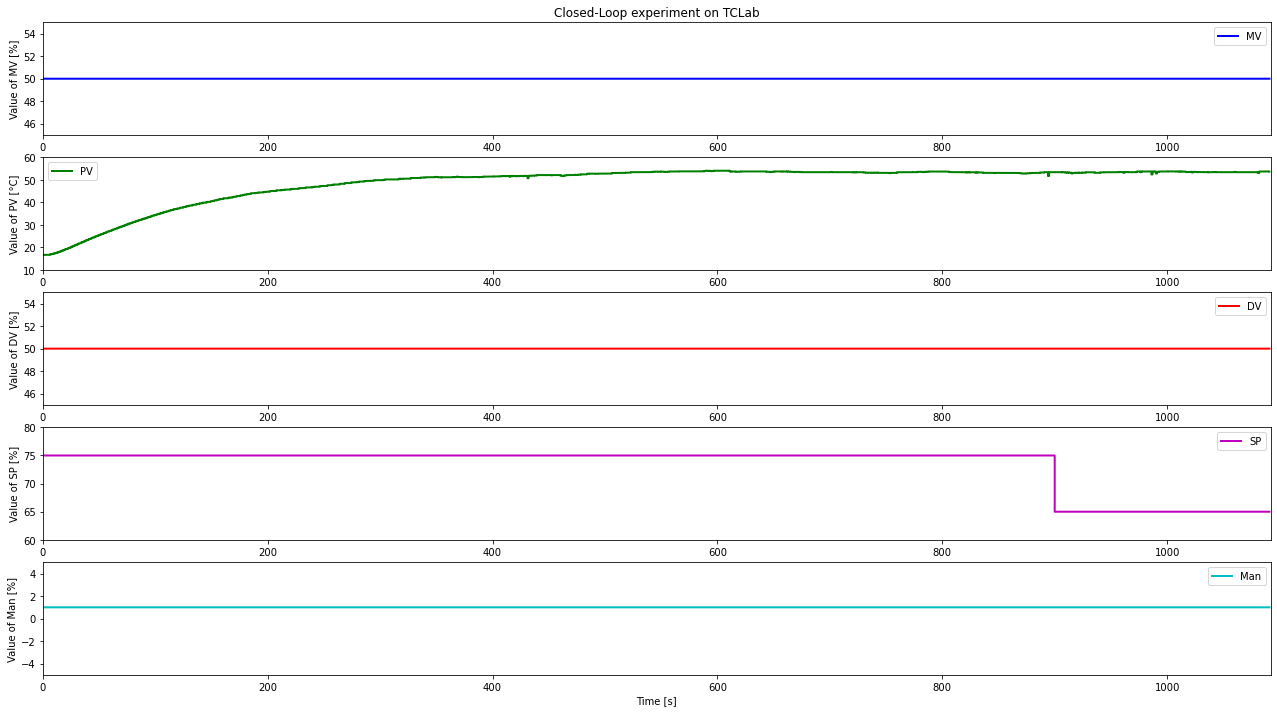

In [ ]:
PV = []
MV = {"MV" : [], "MVp" : [], "MVi": [],  "MVd": [], "E" : []}

N = int(TSim/Ts)+1

t = []
SP = []
DV = []

Man = []
MVMan = []
MVFF = []

MVFFDelay = []
MVFFLL1 = []

MVDelay = []
PV1p = []
PV2p = []

DVDelay = []
PV1d = []
PV2d = []

# Initialize TCLab
lab = tclab.TCLab()
PV0 = lab.T1

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0, 1], [0, 100], 'b-', linewidth=2, label='MV', where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title('Closed-Loop experiment on TCLab')
ax1.legend(loc='best')

l2, = ax2.step([0, 1], [0, 100], 'g-', linewidth=2, label='PV', where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0, 1], [0, 100], 'r-', linewidth=2, label='DV', where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best')

l4, = ax4.step([0, 1], [0, 100], 'm-', linewidth=2, label='SP', where='post')
ax4.set_ylabel('Value of SP [%]')
ax4.legend(loc='best')

l5, = ax5.step([0, 1], [0, 100], 'c-', linewidth=2, label='Man', where='post')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('Value of Man [%]')
ax5.legend(loc='best')



for i in range(0, N):
    
    t.append(i*Ts)

    # Input signal SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)

    # FeedForward
    Delay_RT(DV-DV0*np.ones_like(DV), np.max([Thetad-Thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay,-Kd/Kp, T1d, T1p, Ts, MVFFLL1)
    if ActivateFF:
        LeadLag_RT(MVFFLL1, 1, T2d, T2p, Ts, MVFF)
    else:
        #LeadLag_RT(MVFFLL1, 0, T2d, T2p, Ts, MVFF)
        MVFF.append(0)
    
    # PID controller mode
    SelectPath_RT(manPath,t,Man)
    SelectPath_RT(manMVPath, t, MVMan)
    
    # PID controller
    PID_RT(PV, SP[i], MV, Ts, Kc, Ti, Td, alpha, discretisation, PVinit=PV0, man=Man[i], manMV=MVMan, FF_MV=MVFF)
    # Process Dynamics
    lab.Q1(MV["MV"][-1])


    # Disturbance dynamics
    lab.Q2(DV[-1])

    PV.append(lab.T1)
    #print("PV2p[-1]= {}, PV2d[-1] = {}, PV0 = {}, Kp = {}, MV0 = {}".format(PV2p[-1],PV2d[-1] ,PV0 , Kp , MV0))


    # Display graphs
    l1.set_data(t, MV["MV"])
    l2.set_data(t, PV)
    l3.set_data(t, DV)
    l4.set_data(t, SP)
    l5.set_data(t, Man)

    clear_output(wait=True)
    
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)
    ax5.set_xlim(0, t[-1]+1)

    if i > 1:
        ax1.set_ylim(myRound(np.min(MV["MV"]), 5)-5, myRound(np.max(MV["MV"]), 5)+5)
        ax2.set_ylim(myRound(np.min(PV), 5)-5, myRound(np.max(PV), 5)+5)
        ax3.set_ylim(myRound(np.min(DV), 5)-5, myRound(np.max(DV), 5)+5)
        ax4.set_ylim(myRound(np.min(SP), 5)-5, myRound(np.max(SP), 5)+5)
        ax5.set_ylim(myRound(np.min(Man), 5)-5, myRound(np.max(Man), 5)+5)

    display(fig)

    time.sleep(Ts)

## File Saving

In [ ]:
#MV = {"MV" : [], "MVp" : [], "MVi": [],  "MVd": [], "E" : []}
t = np.array(t)
MVP = np.array(MV["MVp"])
MVI = np.array(MV["MVi"])
MVD = np.array(MV["MVd"])
MV = np.array(MV["MV"])
SP = np.array(SP)
PV = np.array(PV)
DV = np.array(DV)
Man = np.array(Man)
    
# Date time
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")

# Implementation of the file's name
nameFile = 'Data/'

my_data = np.vstack((t.T,MV.T,MVP.T, MVI.T, MVD.T, SP.T, PV.T,DV.T, Man.T))
my_data = my_data.T

if ActivateFF:
    nameFile += 'Real_Time_PID_+_FeedForward_+_Manuel_Mode_'
else:
    nameFile += 'Real_Time_PID_+_NO_FeedForward_'

nameFile += f'On_{date_time}.txt'

if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile, my_data, delimiter=',', header='t,MV,MVP,MVI,MVD,SP,PV,DV,Man', comments='')

if not os.path.exists('Plots'):
    os.makedirs('Plots') 
plt.savefig(nameFile + '.png',transparent=True)
plt.savefig(nameFile + '.pdf',transparent=True)   